In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function

## here are the user-defined functions and classes
# from MarkovComputations import WeightMatrix, StackedWeightMatrices, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, StackedWeightMatrices, StackedWeightMatricesWithPerceptron, InputData, get_input_inds, get_output_inds, random_initial_parameters, evaluate_accuracy, evaluate_accuracy_per_class, compute_error

In [2]:
class StackedWeightMatricesWithPerceptron(StackedWeightMatrices):
    """
    Extends StackedWeightMatrices by adding a perceptron layer implemented in PyTorch.
    The perceptron takes the final steady-state output and performs additional processing.
    """

    def __init__(self, weight_matrix_list,
                external_dims, internal_dims,
                M_vals, A_fac, b_fac,
                perceptron_hidden_dims,  # List of hidden layer dimensions
                perceptron_output_dim,   # Final output dimension
                rand_bool=True):
        """
        Initializes the combined Markov-Perceptron architecture.

        Parameters:
        - weight_matrix_list: List of WeightMatrix objects for the Markov computation
        - external_dims: [external_input_dim, external_output_dim] for Markov layers
        - internal_dims: Internal dimensions for Markov layers
        - M_vals: Number of edges per input for each layer
        - A_fac: Scaling factor for A matrices
        - b_fac: Scaling factor for b vectors
        - perceptron_hidden_dims: List of hidden layer dimensions for the perceptron
        - perceptron_output_dim: Output dimension of the perceptron
        - rand_bool: Whether to use random initialization
        """
        # Initialize the base StackedWeightMatrices
        super().__init__(weight_matrix_list, external_dims, internal_dims, 
                        M_vals, A_fac, b_fac, rand_bool)
        
        # Store perceptron dimensions
        self.perceptron_input_dim = len(self.external_output_inds)
        self.perceptron_hidden_dims = perceptron_hidden_dims
        self.perceptron_output_dim = perceptron_output_dim
        
        # Initialize the perceptron layers
        self._init_perceptron(perceptron_hidden_dims, perceptron_output_dim)

    def _init_perceptron(self, hidden_dims, output_dim):
        """
        Initializes the perceptron layers using PyTorch.
        Creates a multi-layer perceptron with ReLU activations and log-softmax output.
        """
        layers = []
        in_dim = self.perceptron_input_dim

        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                torch.nn.Linear(in_dim, hidden_dim),
                torch.nn.ReLU()
            ])
            in_dim = hidden_dim

        # Add output layer with log-softmax activation for numerical stability
        layers.extend([
            torch.nn.Linear(in_dim, output_dim),
            torch.nn.LogSoftmax(dim=1)
        ])
        
        # Create sequential model
        self.perceptron = torch.nn.Sequential(*layers)
        
        # Loss function
        self.criterion = torch.nn.NLLLoss() # negative log-likelihood

    def compute_combined_output(self, inputs):
        """
        Computes the full forward pass through both Markov and perceptron layers.

        Parameters:
        - inputs: Input data for the Markov computation

        Returns:
        - markov_ss_list: List of steady states from Markov layers
        - inputs_list: List of inputs used at each Markov layer
        - perceptron_output: Final output after perceptron processing (log probabilities)
        """
        # Get Markov steady states
        markov_ss_list, inputs_list = self.compute_stacked_ss_on_inputs(inputs)
        
        # Extract final layer steady states at output indices
        final_ss = np.array(markov_ss_list[-1])  # Convert JAX array to numpy
        markov_outputs = torch.tensor([final_ss[i] for i in self.external_output_inds], 
                                    dtype=torch.float32).unsqueeze(0)
        
        # Forward pass through perceptron
        self.perceptron.eval()  # Set to evaluation mode
        with torch.no_grad():
            log_probs = self.perceptron(markov_outputs)
            perceptron_output = torch.exp(log_probs)  # Convert back to probabilities
        
        return markov_ss_list, inputs_list, perceptron_output
    
    def compute_output(self, inputs):
        """
        Computes output probabilities for the given inputs using the Markov-Perceptron model.
        Returns the perceptron output probabilities as a numpy array.
        """
        _, _, perceptron_output = self.compute_combined_output(inputs)
        return perceptron_output.squeeze().detach().cpu().numpy()

    def compute_combined_gradients(self, inputs, target, markov_ss_list=None, inputs_list=None):
        """
        Computes gradients for both Markov and perceptron parameters.
        Uses chain rule to backpropagate the loss through both the perceptron and Markov components.
        If markov_ss_list and inputs_list are provided, uses them instead of recomputing.
        """
        # Get Markov steady states
        if markov_ss_list is None or inputs_list is None:
            markov_ss_list, inputs_list = self.compute_stacked_ss_on_inputs(inputs)
        
        # Convert JAX arrays to numpy arrays
        markov_ss_list = [np.array(ss) for ss in markov_ss_list]
        inputs_list = [np.array(inp) for inp in inputs_list]
        
        # Extract final layer steady states at output indices
        final_ss = markov_ss_list[-1]
        markov_outputs = torch.tensor([final_ss[i] for i in self.external_output_inds], 
                                    dtype=torch.float32).unsqueeze(0)
        markov_outputs.requires_grad_(True)
        
        # Forward pass through perceptron
        self.perceptron.train() # sets to training mode
        for param in self.perceptron.parameters():
            if param.grad is not None:
                param.grad.zero_() # zero out the gradient if it exists
                
        log_probs = self.perceptron(markov_outputs) 
        
        # Compute loss and get initial gradient
        target_tensor = torch.tensor([target], dtype=torch.long)
        loss = self.criterion(log_probs, target_tensor) # computes the target element of the log_probs
        loss.backward() # gradents are stored in .grad attribute of each parameter
        
        # Get gradient with respect to Markov outputs
        dLoss_dMarkov = markov_outputs.grad.numpy() # get the gradient of the loss with respect to the Markov outputs
        
        # Get perceptron gradients
        perceptron_gradients = {name: param.grad.clone() for name, param in self.perceptron.named_parameters()}
        
        # Compute Markov gradients using the chain rule
        dpiL_dthetal_lists, dpiL_dAl_lists, dpiL_dbl_lists = self.stacked_derivatives_of_ss(markov_ss_list, inputs_list)
        
        # Convert JAX arrays to numpy if needed
        dpiL_dthetal_lists = [[np.array(grad) for grad in layer_grads] for layer_grads in dpiL_dthetal_lists]
        dpiL_dAl_lists = [np.array(grad) for grad in dpiL_dAl_lists]
        dpiL_dbl_lists = [np.array(grad) for grad in dpiL_dbl_lists]
        
        markov_gradients = {
            'theta': [],
            'A': [],
            'b': []
        }
        
        # Process theta gradients for each layer
        for l in range(self.L):
            wm = self.weight_matrix_list[l]
            
            # Initialize gradients with correct shapes
            Ej_grad = np.zeros_like(wm.Ej_list)
            Bij_grad = np.zeros_like(wm.Bij_list)
            Fij_grad = np.zeros_like(wm.Fij_list)
            
            # Accumulate gradients for each output
            for out_idx, out_ind in enumerate(self.external_output_inds):
                # Ensure proper broadcasting by matching shapes
                dtheta = dpiL_dthetal_lists[l]
                Ej_grad += dLoss_dMarkov[0, out_idx] * dtheta[0][out_ind]
                Bij_grad += dLoss_dMarkov[0, out_idx] * dtheta[1][out_ind]
                Fij_grad += dLoss_dMarkov[0, out_idx] * dtheta[2][out_ind]
    
            markov_gradients['theta'].append([Ej_grad, Bij_grad, Fij_grad])
        
        # Process A and b gradients
        for l in range(self.L - 1):
            A_grad = np.zeros_like(self.A_matrices_list[l])
            b_grad = np.zeros_like(self.b_vectors_list[l])
            
            for out_idx, out_ind in enumerate(self.external_output_inds):
                A_grad += dLoss_dMarkov[0, out_idx] * dpiL_dAl_lists[l][out_ind]
                b_grad += dLoss_dMarkov[0, out_idx] * dpiL_dbl_lists[l][out_ind]
            
            markov_gradients['A'].append(A_grad)
            markov_gradients['b'].append(b_grad)
        
        return markov_gradients, perceptron_gradients
    
    def _perceptron_step(self, eta_perceptron):
        """
        Performs a simple gradient descent step on the perceptron parameters.
        
        Parameters:
        - eta_perceptron: Learning rate for perceptron parameters
        """
        with torch.no_grad():
            for layer in self.perceptron:
                if isinstance(layer, torch.nn.Linear):
                    # Update weights
                    layer.weight -= eta_perceptron * layer.weight.grad
                    # Update bias
                    layer.bias -= eta_perceptron * layer.bias.grad

    def update_combined(self, inputs, target, eta_markov, eta_perceptron, markov_ss_list=None, inputs_list=None):
        """
        Updates both Markov and perceptron parameters using computed gradients.
        If markov_ss_list and inputs_list are provided, uses them instead of recomputing.
        """
        # Compute all gradients with proper backpropagation
        markov_gradients, _ = self.compute_combined_gradients(
            inputs, target, markov_ss_list=markov_ss_list, inputs_list=inputs_list
        )
        
        # Update Markov parameters using the backpropagated gradients
        for l in range(self.L):
            Ej_grad, Bij_grad, Fij_grad = markov_gradients['theta'][l]
            wm = self.weight_matrix_list[l]
            
            # Ensure gradients have correct shapes
            Ej_grad = np.asarray(Ej_grad).reshape(wm.Ej_list.shape)
            Bij_grad = np.asarray(Bij_grad).reshape(wm.Bij_list.shape)
            Fij_grad = np.asarray(Fij_grad).reshape(wm.Fij_list.shape)
            
            # Update parameters with shape verification 
            new_Ej = wm.Ej_list - eta_markov * Ej_grad
            new_Bij = wm.Bij_list - eta_markov * Bij_grad
            new_Fij = wm.Fij_list - eta_markov * Fij_grad
               
            # Update parameters
            wm.set_W_mat(new_Ej, new_Bij, new_Fij)
        
        # Update A matrices and b vectors
        for l in range(self.L - 1):
            A_grad = np.asarray(markov_gradients['A'][l]).reshape(self.A_matrices_list[l].shape)
            b_grad = np.asarray(markov_gradients['b'][l]).reshape(self.b_vectors_list[l].shape)

            
            self.A_matrices_list[l] -= eta_markov * A_grad
            self.b_vectors_list[l] -= eta_markov * b_grad
        
        # Update perceptron parameters using simple gradient descent
        self._perceptron_step(eta_perceptron)

    def zero_gradients(self):
        """Initialize/zero accumulators for Markov and perceptron gradients."""
        self.markov_grad_accum = {
            'theta': [[np.zeros_like(wm.Ej_list), np.zeros_like(wm.Bij_list), np.zeros_like(wm.Fij_list)] for wm in self.weight_matrix_list],
            'A': [np.zeros_like(A) for A in self.A_matrices_list],
            'b': [np.zeros_like(b) for b in self.b_vectors_list]
        }
        self.perceptron_grad_accum = {name: torch.zeros_like(param) for name, param in self.perceptron.named_parameters()}

    def compute_gradients_single(self, inputs, target, markov_ss_list=None, inputs_list=None):
        """Compute gradients for a single sample."""
        return self.compute_combined_gradients(inputs, target, markov_ss_list, inputs_list)

    def accumulate_gradients(self, markov_grads, perceptron_grads):
        """Add single-sample gradients to the running total."""
        for l in range(self.L):
            for i in range(3):
                self.markov_grad_accum['theta'][l][i] += markov_grads['theta'][l][i]
        for l in range(self.L - 1):
            self.markov_grad_accum['A'][l] += markov_grads['A'][l]
            self.markov_grad_accum['b'][l] += markov_grads['b'][l]
        for name in self.perceptron_grad_accum:
            self.perceptron_grad_accum[name] += perceptron_grads[name]

    def apply_gradients(self, batch_size, eta_markov, eta_perceptron):
        """Update parameters using the averaged gradients."""
        # Average gradients and update Markov parameters
        for l in range(self.L):
            Ej_grad, Bij_grad, Fij_grad = [g / batch_size for g in self.markov_grad_accum['theta'][l]]
            wm = self.weight_matrix_list[l]
            new_Ej = wm.Ej_list - eta_markov * Ej_grad
            new_Bij = wm.Bij_list - eta_markov * Bij_grad
            new_Fij = wm.Fij_list - eta_markov * Fij_grad
            wm.set_W_mat(new_Ej, new_Bij, new_Fij)
        for l in range(self.L - 1):
            self.A_matrices_list[l] -= eta_markov * (self.markov_grad_accum['A'][l] / batch_size)
            self.b_vectors_list[l] -= eta_markov * (self.markov_grad_accum['b'][l] / batch_size)
        # Average gradients and update perceptron parameters
        with torch.no_grad():
            for name, param in self.perceptron.named_parameters():
                param -= eta_perceptron * (self.perceptron_grad_accum[name] / batch_size)

    def apply_adam_gradients(self, batch_size, eta_markov, eta_perceptron, beta1, beta2, epsilon):
        """
        Update parameters using the Adam optimizer with batch-averaged gradients.
        Maintains Adam state for each parameter.
        """
        # Initialize Adam state if not present
        if not hasattr(self, 'adam_state'):
            self.adam_state = {'t': 0, 'markov': {'theta': [], 'A': [], 'b': []}, 'perceptron': {}}
            # Markov parameters
            for l in range(self.L):
                wm = self.weight_matrix_list[l]
                self.adam_state['markov']['theta'].append([
                    {'m': np.zeros_like(wm.Ej_list), 'v': np.zeros_like(wm.Ej_list)},
                    {'m': np.zeros_like(wm.Bij_list), 'v': np.zeros_like(wm.Bij_list)},
                    {'m': np.zeros_like(wm.Fij_list), 'v': np.zeros_like(wm.Fij_list)}
                ])
            for l in range(self.L - 1):
                self.adam_state['markov']['A'].append({'m': np.zeros_like(self.A_matrices_list[l]), 'v': np.zeros_like(self.A_matrices_list[l])})
                self.adam_state['markov']['b'].append({'m': np.zeros_like(self.b_vectors_list[l]), 'v': np.zeros_like(self.b_vectors_list[l])})
            # Perceptron parameters
            for name, param in self.perceptron.named_parameters():
                self.adam_state['perceptron'][name] = {
                    'm': torch.zeros_like(param),
                    'v': torch.zeros_like(param)
                }
        # Increment timestep
        self.adam_state['t'] += 1
        t = self.adam_state['t']
        # --- Markov parameters ---
        for l in range(self.L):
            Ej_grad, Bij_grad, Fij_grad = [g / batch_size for g in self.markov_grad_accum['theta'][l]]
            wm = self.weight_matrix_list[l]
            for i, (grad, param, state) in enumerate(zip([Ej_grad, Bij_grad, Fij_grad],
                                                         [wm.Ej_list, wm.Bij_list, wm.Fij_list],
                                                         self.adam_state['markov']['theta'][l])):
                # Update moments
                state['m'] = beta1 * state['m'] + (1 - beta1) * grad
                state['v'] = beta2 * state['v'] + (1 - beta2) * (grad ** 2)
                m_hat = state['m'] / (1 - beta1 ** t)
                v_hat = state['v'] / (1 - beta2 ** t)
                # Adam update
                param -= eta_markov * m_hat / (np.sqrt(v_hat) + epsilon)
            # Set updated parameters
            wm.set_W_mat(wm.Ej_list, wm.Bij_list, wm.Fij_list)
            print(wm.Ej_list)
        for l in range(self.L - 1):
            A_grad = self.markov_grad_accum['A'][l] / batch_size
            b_grad = self.markov_grad_accum['b'][l] / batch_size
            A_state = self.adam_state['markov']['A'][l]
            b_state = self.adam_state['markov']['b'][l]
            # Update moments for A
            A_state['m'] = beta1 * A_state['m'] + (1 - beta1) * A_grad
            A_state['v'] = beta2 * A_state['v'] + (1 - beta2) * (A_grad ** 2)
            m_hat_A = A_state['m'] / (1 - beta1 ** t)
            v_hat_A = A_state['v'] / (1 - beta2 ** t)
            self.A_matrices_list[l] -= eta_markov * m_hat_A / (np.sqrt(v_hat_A) + epsilon)
            # Update moments for b
            b_state['m'] = beta1 * b_state['m'] + (1 - beta1) * b_grad
            b_state['v'] = beta2 * b_state['v'] + (1 - beta2) * (b_grad ** 2)
            m_hat_b = b_state['m'] / (1 - beta1 ** t)
            v_hat_b = b_state['v'] / (1 - beta2 ** t)
            self.b_vectors_list[l] -= eta_markov * m_hat_b / (np.sqrt(v_hat_b) + epsilon)
        # --- Perceptron parameters ---
        with torch.no_grad():
            for name, param in self.perceptron.named_parameters():
                grad = self.perceptron_grad_accum[name] / batch_size
                state = self.adam_state['perceptron'][name]
                # Update moments
                state['m'] = beta1 * state['m'] + (1 - beta1) * grad
                state['v'] = beta2 * state['v'] + (1 - beta2) * (grad ** 2)
                m_hat = state['m'] / (1 - beta1 ** t)
                v_hat = state['v'] / (1 - beta2 ** t)
                # Adam update
                param -= eta_perceptron * m_hat / (torch.sqrt(v_hat) + epsilon)

    def compute_input_gradient(self, inputs, class_idx):
        """
        Computes the gradient of the perceptron output (for class_idx) with respect to the input vector.
        Args:
            inputs: input vector (numpy array or torch tensor)
            class_idx: integer, class index to maximize
        Returns:
            grad: numpy array, gradient of class prediction wrt input vector
        """
        # Ensure input is a torch tensor with gradients enabled
        if not torch.is_tensor(inputs):
            inputs = torch.tensor(inputs, dtype=torch.float32, requires_grad=True)
        else:
            inputs = inputs.clone().detach().requires_grad_(True)

        # Forward pass through Markov layers (using numpy, so detach and re-wrap as torch)
        ss_list, inputs_list = self.compute_stacked_ss_on_inputs(inputs.detach().cpu().numpy())
        final_ss = np.array(ss_list[-1])
        markov_outputs = torch.tensor([final_ss[i] for i in self.external_output_inds], dtype=torch.float32).unsqueeze(0)
        markov_outputs.requires_grad_(True)

        self.perceptron.eval()
        output = self.perceptron(markov_outputs)
        prob = torch.exp(output)[0, class_idx]
     
        # Backpropagate to markov_outputs
        self.perceptron.zero_grad()
        prob.backward(retain_graph=True)
        dprob_dmarkov = markov_outputs.grad.clone().detach().cpu().numpy()[0]


        dpiL_dthetal_lists, _, _ = self.stacked_derivatives_of_ss(ss_list, inputs_list)
        full_inds = self.external_input_inds
        n_nodes = self.weight_matrix_list[-1].n_nodes
        dpiL_dInputs = np.zeros((n_nodes, len(inputs)))
        for m, inds in enumerate(full_inds):  # Iterate over columns
            dpiL_dInputs[:, m] = np.sum(
                [dpiL_dthetal_lists[0][2][:, ind] for ind in inds], axis=0)
        dpioL_dInputs = dpiL_dInputs[self.external_output_inds, :]

        grad = np.dot(dprob_dmarkov, dpioL_dInputs)
        return grad

In [3]:
# Define basic parameters
M = 2                  # edges affected per input dimension
n_classes = 2          # number of classes
input_dim = 1          # components of each input data
n_nodes = 10           # nodes per graph
L = 1                 # number of Markov layers

# Create a complete graph
g = nx.complete_graph(n_nodes)
n_edges = len(list(g.edges()))

E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create list of identical weight matrices
weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for _ in range(L)]

# Define dimensions
external_input_dim = 1
external_output_dim = 3
internal_input_dims = []
internal_output_dims = []
external_dims = [external_input_dim, external_output_dim]
internal_dims = [internal_input_dims, internal_output_dims]              # internal dimensions between layers
M_vals = [M] 

# # Define dimensions
# external_input_dim = 1
# external_output_dim = 10
# internal_input_dims = []
# internal_output_dims = []
# external_dims = [external_input_dim, external_output_dim]
# internal_dims = [internal_input_dims, internal_output_dims]              # internal dimensions between layers
# M_vals = [M]                              # edges per input for each layer

# Network parameters
A_fac = 20           # scaling factor for A matrices
b_fac = 0            # scaling factor for b vectors

# Perceptron parameters
perceptron_hidden_dims = [10]     # single hidden layer
perceptron_output_dim = n_classes

# Create the combined network
network = StackedWeightMatricesWithPerceptron(
    weight_matrix_list=weight_matrix_list,
    external_dims=external_dims,
    internal_dims=internal_dims,
    M_vals=M_vals,
    A_fac=A_fac,
    b_fac=b_fac,
    perceptron_hidden_dims=perceptron_hidden_dims,
    perceptron_output_dim=perceptron_output_dim,
    rand_bool=True  # Use deterministic initialization for testing
)

In [68]:

# Test forward pass with a simple input
test_input = np.array([-10.0])  # Single input value
markov_ss_list, inputs_list, perceptron_output = network.compute_combined_output(test_input)

print("Network initialization complete!")
print(f"Input shape: {test_input.shape}")
print(f"Number of Markov layers: {L}")
print(f"Final Markov steady state shape: {markov_ss_list[-1].shape}")
print(f"Perceptron output shape: {perceptron_output.shape}")
print(f"Perceptron output: {perceptron_output}")

Network initialization complete!
Input shape: (1,)
Number of Markov layers: 1
Final Markov steady state shape: (10,)
Perceptron output shape: torch.Size([1, 2])
Perceptron output: tensor([[0.0838, 0.9162]])


In [4]:
# Create synthetic data
np.random.seed(42)  # for reproducibility

# Generate two classes of data
n_samples_per_class = 10000
class_number = 0

# Class 0: Positive values with some noise
class_0_data = [np.array([10 + 0.1 * np.random.randn()]) for _ in range(n_samples_per_class)]

# Class 1: Negative values with some noise
class_1_data = [np.array([-10 + 0.1 * np.random.randn()]) for _ in range(n_samples_per_class)]

# Create InputData object
data_list = [class_0_data, class_1_data]
input_data = InputData(n_classes=2, data_list=data_list, split_fac=0.75)

# Test data generation
print("Sample from Class 0:", next(input_data.training_data[0]))
print("Sample from Class 1:", next(input_data.training_data[1]))
print("\nNumber of training samples per class:", int(n_samples_per_class * 0.75))
print("Number of test samples per class:", int(n_samples_per_class * 0.25))

Sample from Class 0: [9.99373604]
Sample from Class 1: [-9.96591354]

Number of training samples per class: 7500
Number of test samples per class: 2500


In [5]:
################################################
################  Run training #################
################################################
### Define parameters of trainig
n_training_iters = 500 # how many training steps to take
#eta_markov = 6
#eta_perceptron = 1.5  # Typically want smaller learning rate for neural networks  
batch_size = 5
accuracy_stride = 5

# Adam optimizer hyperparameters
# eta_markov = 1
# eta_perceptron = 0.25  # Typically want smaller learning rate for neural networks
eta_markov = 5e-3
eta_perceptron = 5e-3  # Typically want smaller learning rate for neural networks
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-8

error_list = [] # track errors during training
accuracy_list = [] # track errors during training


print("Starting training.")


for training_iter in range(n_training_iters):

    network.zero_gradients()  # Zero the accumulators at the start of each batch

    for _ in range(batch_size):
        class_number = random.randrange(n_classes)  # draw a random class label to present

        try:
            inputs = next(input_data.training_data[class_number])
        except StopIteration:
            input_data.refill_iterators()  # Refill iterators if exhausted
            inputs = next(input_data.training_data[class_number])  # Try again

        # Compute gradients for this sample
        markov_grads, perceptron_grads = network.compute_gradients_single(inputs, class_number)
        # Accumulate gradients
        network.accumulate_gradients(markov_grads, perceptron_grads)

        # Optionally, you can compute and store the error for this sample
        markov_ss_list, inputs_list, perceptron_output = network.compute_combined_output(inputs)
        target = torch.tensor([class_number], dtype=torch.long)
        error_list.append(network.criterion(torch.log(perceptron_output), target).item())

    # After accumulating over the batch, apply the Adam optimizer update (to be implemented)
    network.apply_adam_gradients(batch_size, eta_markov, eta_perceptron, adam_beta1, adam_beta2, adam_epsilon)
    #network.apply_gradients(batch_size, eta_markov, eta_perceptron)
    # Placeholder: implement apply_adam_gradients in the network class



    # Compute accuracy using the perceptron-based network
    if (training_iter % accuracy_stride == 0):
        print(training_iter)
        accuracy_list.append(
            evaluate_accuracy(network, input_data, n_classes, 10)
        )
    


Starting training.
[-0.00499989  0.00499998 -0.00499989 -0.00499989 -0.00499989  0.00499998
 -0.00499994  0.00499983 -0.00499999 -0.00499989]
0
[-0.00995412  0.00998179 -0.00995412 -0.00995411 -0.00995412  0.00998025
 -0.00993942  0.009812   -0.0099938  -0.00995413]
[-0.01482114  0.01493132 -0.01482131 -0.01482124 -0.01482126  0.01492355
 -0.01474972  0.01406142 -0.01497508 -0.01482122]
[-0.0195494   0.01983262 -0.01955004 -0.01954982 -0.01954987  0.01980907
 -0.01932756  0.01700945 -0.01993537 -0.01954968]
[-0.02407426  0.02466597 -0.02407575 -0.02407527 -0.02407535  0.02461252
 -0.02352052  0.017919   -0.02486369 -0.02407489]
[-0.02831758  0.02940789 -0.02832026 -0.02831943 -0.02831954  0.02930615
 -0.0271195   0.01687757 -0.02974632 -0.02831871]
5
[-0.0321838   0.0340269  -0.03218779 -0.03218658 -0.03218673  0.03385965
 -0.02987323  0.01450305 -0.03456621 -0.03218549]
[-0.03556049  0.03848163 -0.03556558 -0.03556404 -0.03556423  0.03824079
 -0.03154552  0.01129249 -0.03930271 -0.035

KeyboardInterrupt: 

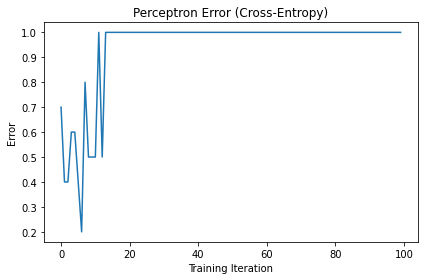

In [5]:
# Plot training curves
plt.figure(figsize=(6, 4))



#plt.subplot(1, 2, 2)
plt.plot(accuracy_list)
plt.title('Perceptron Error (Cross-Entropy)')
plt.xlabel('Training Iteration')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# # Final evaluation
# print("\nFinal Evaluation:")
# n_eval = 100
# accuracy = network.evaluate_accuracy_combined(input_data, n_classes, n_eval)
# print(f"Test Accuracy over {n_eval} samples: {accuracy:.3f}")

Starting training...
Iteration 100
Perceptron Error: 1.0296
Current Output Probabilities: [0.35713667 0.64286333]

Iteration 200
Perceptron Error: 0.7182
Current Output Probabilities: [0.4876088 0.5123912]

Iteration 300
Perceptron Error: 0.7140
Current Output Probabilities: [0.5102963  0.48970377]

Iteration 400
Perceptron Error: 0.9687
Current Output Probabilities: [0.6204237  0.37957633]

Iteration 500
Perceptron Error: 1.0419
Current Output Probabilities: [0.64720124 0.3527988 ]

Iteration 600
Perceptron Error: 0.5970
Current Output Probabilities: [0.4495176  0.55048233]

Iteration 700
Perceptron Error: 0.6783
Current Output Probabilities: [0.49252585 0.5074741 ]

Iteration 800
Perceptron Error: 0.1004
Current Output Probabilities: [0.90447855 0.09552141]

Iteration 900
Perceptron Error: 0.0108
Current Output Probabilities: [0.01077359 0.9892264 ]

Iteration 1000
Perceptron Error: 0.0095
Current Output Probabilities: [0.99050355 0.00949643]



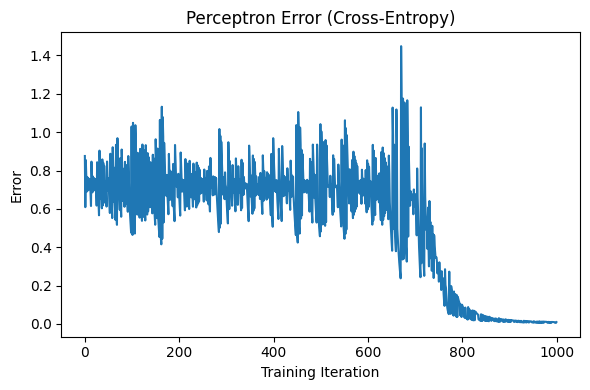


Final Evaluation:
Test Accuracy over 100 samples: 1.000


In [19]:
# Save original network state
network_orig = copy.deepcopy(network)

# Track errors during training
markov_error_list = []  # Track Markov network errors
perceptron_error_list = []  # Track perceptron classification errors

# Training parameters
n_training_iters = 1000
eta_markov = 1.5
eta_perceptron = 0.1  # Typically want smaller learning rate for neural networks

print("Starting training...")
for training_iter in range(n_training_iters):
    # Draw a random class label and get next data point
    class_number = random.randrange(n_classes)
    try:
        inputs = next(input_data.training_data[class_number])
    except StopIteration:
        input_data.refill_iterators()
        inputs = next(input_data.training_data[class_number])
    
    # Compute forward pass
    markov_ss_list, inputs_list, perceptron_output = network.compute_combined_output(inputs)

    
    
    # Perceptron error (cross-entropy loss)
    target = torch.tensor([class_number], dtype=torch.long)
    perceptron_error = network.criterion(torch.log(perceptron_output), target).item()
    perceptron_error_list.append(perceptron_error)
    
    # Update network parameters
    network.update_combined(
        inputs, class_number, eta_markov, eta_perceptron,
        markov_ss_list=markov_ss_list, inputs_list=inputs_list
    )
    
    # Print progress every 50 iterations
    if (training_iter + 1) % 100 == 0:
        print(f"Iteration {training_iter + 1}")
        #print(f"Markov Error: {markov_error:.4f}")
        print(f"Perceptron Error: {perceptron_error:.4f}")
        print(f"Current Output Probabilities: {perceptron_output.squeeze().numpy()}\n")

# Plot training curves
plt.figure(figsize=(6, 4))



#plt.subplot(1, 2, 2)
plt.plot(perceptron_error_list)
plt.title('Perceptron Error (Cross-Entropy)')
plt.xlabel('Training Iteration')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Evaluation:")
n_eval = 100
accuracy = network.evaluate_accuracy_combined(input_data, n_classes, n_eval)
print(f"Test Accuracy over {n_eval} samples: {accuracy:.3f}")

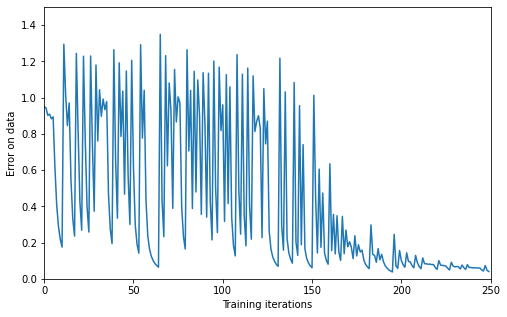

IndexError: list index out of range

In [60]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
plt.xlim(0,n_training_iters)
plt.show()


# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = np.zeros((len(x_values), len(output_inds)))


out_ind = 1
for (i, x) in enumerate(x_values):
    
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    ss_at_outputs = [ss_list[-1][out] for out in stacked_weight_matrices.external_output_inds]
    ss_values[i,:] = ss_at_outputs  # Assuming node index 1 is of interest


# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values[:,0], label="Steady State at Node 1", color='b')
plt.plot(x_values, ss_values[:,1], label="Steady State at Node 2", color='r')

plt.hist(dist_1, density=True, color='b')
plt.hist(dist_2, density=True, color='r')

plt.xlabel("Input")
plt.ylabel("Steady State Value")
plt.ylim(0,1.)
#plt.legend()
plt.show()



In [57]:
stacked_weight_matrices.A_matrices_list

[Array([[ 1.9995386e+01, -4.4196192e-03, -7.9744169e-03],
        [ 4.1260510e-03,  2.0004108e+01,  2.2389164e-02],
        [ 1.5631167e-02,  1.4046709e-02,  2.0022772e+01]], dtype=float32),
 Array([[19.86663   , -0.11609805, -0.27625734],
        [-0.18067127, 19.843267  , -0.43722352],
        [-0.25573188, -0.22933728, 19.520466  ]], dtype=float32)]

[Array([-0.0235416 ,  0.06740638, -0.39308408], dtype=float32),
 Array([ 0.7976702, -9.0069275,  8.172239 ], dtype=float32)]

In [2]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import time
import random
import copy
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist
from sklearn import datasets
import pickle
import argparse
import torch


## here are the user-defined functions and classes
#from MarkovComputations import StackedWeightMatrices, WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error, downsample_avg, load_and_format_mnist, load_and_format_iris, evaluate_accuracy, evaluate_accuracy, evaluate_accuracy_per_class

from MarkovComputations import StackedWeightMatricesWithPerceptron, StackedWeightMatrices, WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error, downsample_avg, load_and_format_mnist, load_and_format_iris, evaluate_accuracy, evaluate_accuracy, evaluate_accuracy_per_class


#########################################################
################  Parameter definitions #################
#########################################################

#random.seed(args.param1)
random.seed(10)

### Define parameters of classification
#M = 10 # how many edges affected per input dimension
M = 2
#M = args.param1
# n_classes = 5 # D, how many classes

classes = [0,1]
#classes = [0,7,8]
#classes = [0,1,2,3,4,5,6,7,8,9]
n_classes = len(classes)

#input_dim = 14**2 # D, how many components of each input data

#n_classes = 2
input_dim = 14**2

### Define parameters of graph object and initial weights
n_nodes = 10 # assuming a complete graph
#n_nodes = args.param1
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

#dim = args.param1
#dim = 50
dim = 30
L = 1
external_input_dim = input_dim
external_output_dim = 10

if L == 2:
    internal_input_dims = [dim+10]
    internal_output_dims = [dim]
    M_vals = [M for l in range(L)]
    n_nodes_list = [n_nodes for l in range(L)]

if L == 1:
    internal_input_dims = []
    internal_output_dims = []
    M_vals = [M for l in range(L)]
    n_nodes_list = [n_nodes for l in range(L)]

external_dims = [external_input_dim, external_output_dim]
internal_dims = [internal_input_dims, internal_output_dims] 

perceptron_hidden_dims = [32]
perceptron_output_dim = n_classes

A_fac = 10
b_fac = 0


rand_output_bool = False

####################################################################
################  Initialize stacked weight_matrix #################
####################################################################

weight_matrix_list = []
for l in range(L):
    n_nodes = n_nodes_list[l]
    g = nx.complete_graph(n_nodes)
    n_edges = len(list(g.edges())) 
    Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)
    weight_matrix_list.append(WeightMatrix(g, Ej_list, Bij_list, Fij_list))

    
external_input_inds = get_input_inds(n_edges, input_dim, M)
# Create the combined network
network = StackedWeightMatricesWithPerceptron(
    weight_matrix_list=weight_matrix_list,
    external_dims=external_dims,
    internal_dims=internal_dims,
    M_vals=M_vals,
    A_fac=A_fac,
    b_fac=b_fac,
    perceptron_hidden_dims=perceptron_hidden_dims,
    perceptron_output_dim=perceptron_output_dim,
    rand_bool=False  
)


############################################################
################  Load classification data #################
############################################################

input_data = load_and_format_mnist(classes, 10, 2)
#input_data = load_and_format_mnist(n_classes, 10, 2)

# ######  Gaussian example
# n_samples = 20000

# ## high-dimensional example
# mu_1 = -10 * np.ones(input_dim)
# cov_1 = 1.0 * np.diag(np.ones(input_dim))
# dist_1 = np.random.multivariate_normal(mu_1, cov_1, n_samples)

# mu_2 = 10 * np.ones(input_dim)
# cov_2 = 1.0 * np.diag(np.ones(input_dim))
# dist_2 = np.random.multivariate_normal(mu_2, cov_2, n_samples)

#data_list = [[dat for dat in dist_1], [dat for dat in dist_2]]

###  create InputData object
#input_data = InputData(n_classes, data_list)



################################################
################  Run training #################
################################################

accuracy_stride = 10
### Define parameters of trainig
n_training_iters = 200 # how many training steps to take
# eta_markov = 1.5
# eta_perceptron = 0.25  # Typically want smaller learning rate for neural networks
eta_markov = 2.5
eta_perceptron = 0.5  # Typically want smaller learning rate for neural networks
batch_size = 10

error_list = [] # track errors during training
accuracy_list = [] # track errors during training

print("Starting training.")

start_time = time.time()
for training_iter in range(n_training_iters):

    network.zero_gradients()  # Zero the accumulators at the start of each batch

    for _ in range(batch_size):
        class_number = random.randrange(n_classes)  # draw a random class label to present

        try:
            inputs = next(input_data.training_data[class_number])
        except StopIteration:
            input_data.refill_iterators()  # Refill iterators if exhausted
            inputs = next(input_data.training_data[class_number])  # Try again

        # Compute gradients for this sample
        markov_grads, perceptron_grads = network.compute_gradients_single(inputs, class_number)
        # Accumulate gradients
        network.accumulate_gradients(markov_grads, perceptron_grads)

        # Optionally, you can compute and store the error for this sample
        # markov_ss_list, inputs_list, perceptron_output = network.compute_combined_output(inputs)
        # target = torch.tensor([class_number], dtype=torch.long)
        # error_list.append(network.criterion(torch.log(perceptron_output), target).item())

    # After accumulating over the batch, apply the averaged gradients
    network.apply_gradients(batch_size, eta_markov, eta_perceptron)

    # Compute accuracy using the perceptron-based network
    if (training_iter % accuracy_stride == 0):
        accuracy_list.append(
            evaluate_accuracy(network, input_data, n_classes, 100)
        )

end_time = time.time()

Starting training.


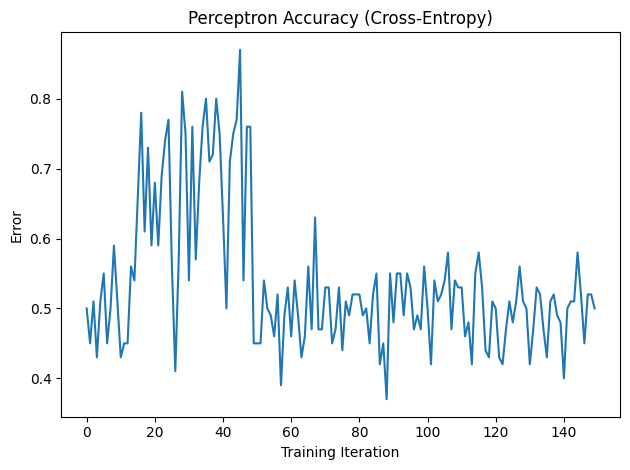

In [38]:
import matplotlib.pyplot as plt
#plt.subplot(1, 2, 2)
plt.plot(accuracy_list)
plt.title('Perceptron Accuracy (Cross-Entropy)')
plt.xlabel('Training Iteration')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

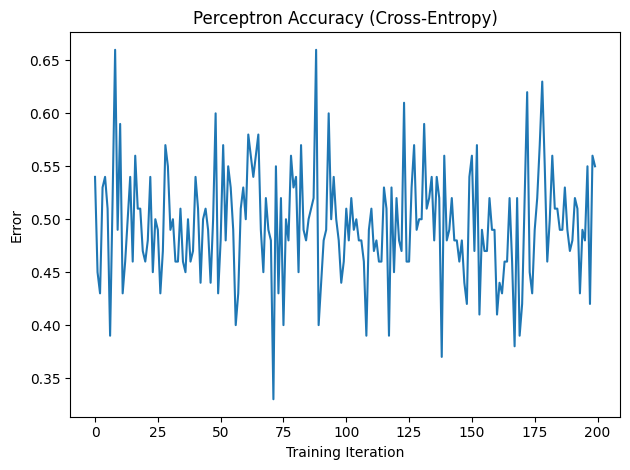

In [59]:
import matplotlib.pyplot as plt
#plt.subplot(1, 2, 2)
plt.plot(accuracy_list)
plt.title('Perceptron Accuracy (Cross-Entropy)')
plt.xlabel('Training Iteration')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

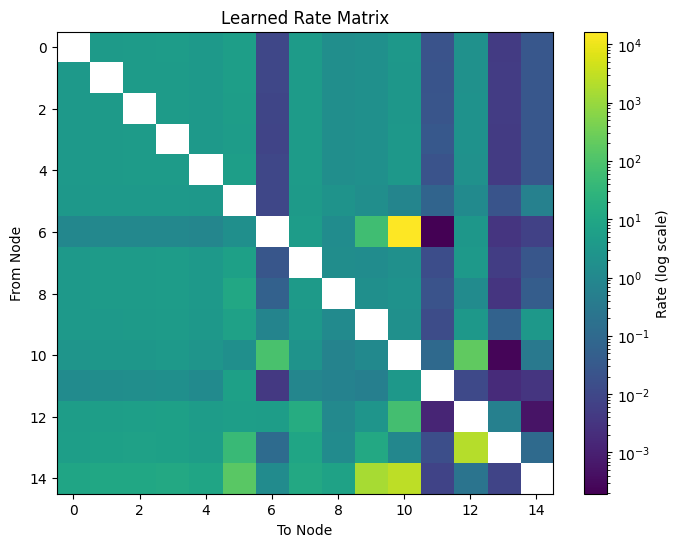

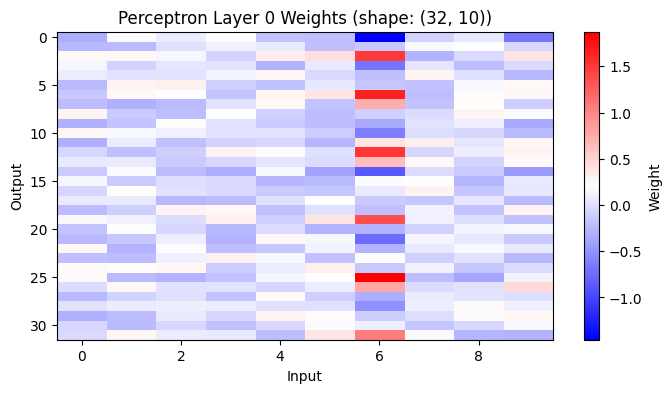

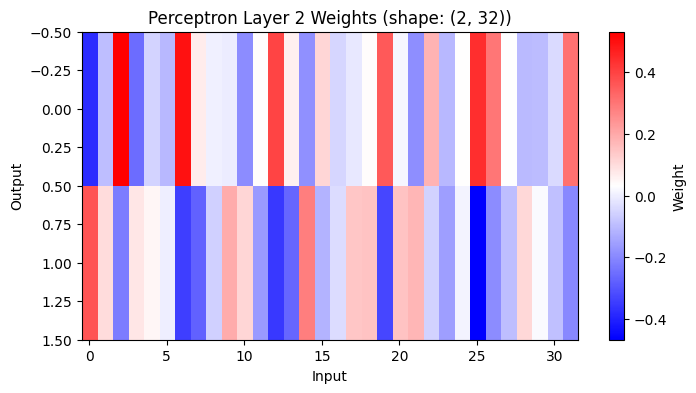

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_rate_matrix(weight_matrix, title="Learned Rate Matrix"):
    W = weight_matrix.W_mat.copy()  # Make a copy to avoid modifying original
    #np.fill_diagonal(W, 0)  # Zero out diagonal elements
    plt.figure(figsize=(8, 6))
    plt.imshow(W, cmap='viridis', aspect='auto', norm='log')  # Add log scale
    plt.colorbar(label='Rate (log scale)')
    plt.title(title)
    plt.xlabel('To Node')
    plt.ylabel('From Node')
    plt.show()
    
def plot_perceptron_weights(perceptron):
    for i, layer in enumerate(perceptron):
        if isinstance(layer, torch.nn.Linear):
            weights = layer.weight.detach().cpu().numpy()
            plt.figure(figsize=(8, 4))
            plt.imshow(weights, cmap='bwr', aspect='auto')
            plt.colorbar(label='Weight')
            plt.title(f'Perceptron Layer {i} Weights (shape: {weights.shape})')
            plt.xlabel('Input')
            plt.ylabel('Output')
            plt.show()

    # For a single Markov layer
plot_rate_matrix(network.weight_matrix_list[0])

plot_perceptron_weights(network.perceptron)
# # For all layers in a stacked model
# for i, wm in enumerate(network.weight_matrix_list):
#     plot_rate_matrix(wm, title=f"Layer {i} Rate Matrix")

In [54]:
import numpy as np
import torch

def finite_difference_grad(model, inputs, target, param_getter, param_setter, epsilon=1e-2):
    """
    Estimates the gradient of the loss with respect to a parameter using finite differences.
    param_getter: function to get the parameter (returns a numpy array)
    param_setter: function to set the parameter (takes a numpy array)
    """
    param = param_getter()
    grad_estimate = np.zeros_like(param)
    it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
    for x in it:
        idx = it.multi_index
        orig = param[idx]
        
        # f(x + eps)
        param[idx] = orig + epsilon
        param_setter(param)
        _, _, out_plus = model.compute_combined_output(inputs)
        loss_plus = -np.log(out_plus[0, target].item())
        
        # f(x - eps)
        param[idx] = orig - epsilon
        param_setter(param)
        _, _, out_minus = model.compute_combined_output(inputs)
        loss_minus = -np.log(out_minus[0, target].item())
        
        # Restore original value
        param[idx] = orig
        param_setter(param)
        
        grad_estimate[idx] = (loss_plus - loss_minus) / (2 * epsilon)
    return grad_estimate


model = network
try:
    inputs = next(input_data.training_data[class_number])
except StopIteration:
    input_data.refill_iterators()
    inputs = next(input_data.training_data[class_number])



# Perceptron error (cross-entropy loss)
target = torch.tensor([class_number], dtype=torch.long)
# --- 3. Analytical gradients ---
markov_grads, perceptron_grads = model.compute_combined_gradients(inputs, target)

# --- 4. Finite difference gradients for Markov parameters ---
print("Testing Markov parameter gradients:")
for l, wm in enumerate(model.weight_matrix_list):
    # E_j
    def get_Ej(): return wm.Ej_list.copy()
    def set_Ej(val):
        wm.set_W_mat(val, wm.Bij_list, wm.Fij_list)
    fd_Ej = finite_difference_grad(model, inputs, target, get_Ej, set_Ej)
    #print(fd_Ej)
    #print(markov_grads['theta'][l][0])
    print(f"Layer {l} E_j grad diff:", np.linalg.norm(fd_Ej - markov_grads['theta'][l][0]))
    
    # B_ij
    def get_Bij(): return wm.Bij_list.copy()
    def set_Bij(val):
        wm.set_W_mat(wm.Ej_list, val, wm.Fij_list)
    fd_Bij = finite_difference_grad(model, inputs, target, get_Bij, set_Bij)
    #print(fd_Bij)
    #print(markov_grads['theta'][l][1])
    print(f"Layer {l} B_ij grad diff:", np.linalg.norm(fd_Bij - markov_grads['theta'][l][1]))
    
    # F_ij
    def get_Fij(): return wm.Fij_list.copy()
    def set_Fij(val):
        wm.set_W_mat(wm.Ej_list, wm.Bij_list, val)
    fd_Fij = finite_difference_grad(model, inputs, target, get_Fij, set_Fij)
    print(f"Layer {l} F_ij grad diff:", np.linalg.norm(fd_Fij - markov_grads['theta'][l][2]))

    if l < len(model.A_matrices_list):
        # A matrix
        def get_A(): return model.A_matrices_list[l].copy()
        def set_A(val): model.A_matrices_list[l] = val
        fd_A = finite_difference_grad(model, inputs, target, get_A, set_A)
        print(f"Layer {l} A matrix grad diff:", np.linalg.norm(fd_A - markov_grads['A'][l]))

        # b vector
        def get_b(): return model.b_vectors_list[l].copy()
        def set_b(val): model.b_vectors_list[l] = val
        fd_b = finite_difference_grad(model, inputs, target, get_b, set_b)
        print(f"Layer {l} b vector grad diff:", np.linalg.norm(fd_b - markov_grads['b'][l]))

# --- 5. Finite difference gradients for perceptron parameters ---
print("Testing perceptron parameter gradients:")
for name, param in model.perceptron.named_parameters():
    def get_param(): return param.detach().numpy().copy()
    def set_param(val): param.data = torch.from_numpy(val).float()
    fd_param = finite_difference_grad(model, inputs, target, get_param, set_param)
    analytic_param = perceptron_grads[name].detach().numpy()
    #print(fd_param)
    #print(analytic_param)
    print(f"{name} grad diff:", np.linalg.norm(fd_param - analytic_param))



array([[-5.34214797e+01,  4.20272625e+00,  4.34712071e+00,
         4.55955711e+00,  3.65808613e+00,  5.41198494e+00,
         9.51878794e-03,  4.39808378e+00,  1.61755685e+00,
         1.85084772e+00,  3.21484763e+00,  2.16177681e-02,
         2.02161837e+00,  4.74570335e-03,  2.72946147e-02],
       [ 3.69793251e+00, -6.05984035e+01,  4.32682619e+00,
         4.50459035e+00,  3.63339059e+00,  5.29599934e+00,
         9.30384803e-03,  4.36326273e+00,  1.62864197e+00,
         1.81107758e+00,  3.12380283e+00,  2.29237831e-02,
         2.05452830e+00,  4.92552160e-03,  2.76813559e-02],
       [ 3.68473757e+00,  4.16912378e+00, -6.23776174e+01,
         4.46284718e+00,  3.62614511e+00,  5.16591545e+00,
         9.09677714e-03,  4.36358043e+00,  1.64646965e+00,
         1.80045693e+00,  3.06610757e+00,  2.39354447e-02,
         2.08079334e+00,  5.10743536e-03,  2.69406006e-02],
       [ 3.71891815e+00,  4.18713455e+00,  4.31579007e+00,
        -6.61816406e+01,  3.61943264e+00,  4.84654815